In [1]:
import os
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from gensim.models import Word2Vec

C:\Users\James\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Train Word2Vec Embedding

Vectorise the input text data by training a new embedding using gensim's Word2Vec.

File paths

In [2]:
path = Path('..')

TRAIN_SET = path / 'Data' / 'Tokenised_Text' / 'tokenised_train_custom_stopwords.csv'
TEST_SET = path / 'Data' / 'Tokenised_Text' / 'tokenised_test_custom_stopwords.csv'

OUT_PATH = path / 'Data' / 'Sequenced_Text'
EMBEDDING_OUT_PATH = path / 'Embedding_Build' / 'Trained_Embeddings' / 'word2vec_embedding_weights_custom_stopwords.csv'
W2V_TRANSFORMER_OUT_PATH = path / 'Model_Build' / 'Trained_Models' / 'word2vec_model_custom_stopwords.pkl'

train_out_path = OUT_PATH / 'word2vec_train_custom_stopwords.csv'
test_out_path = OUT_PATH / 'word2vec_test_custom_stopwords.csv'

Word2Vec parameters

In [3]:
EMBEDDING_DIMENSIONS = 100
MIN_COUNT = 1
WINDOW = 5

## Load corpus to train on

Mark empty entries to capture potential meaning. Probably the preprocessing step that made them empty.

In [4]:
train = pd.read_csv(TRAIN_SET)
test = pd.read_csv(TEST_SET)
train['comment_text'].fillna('emptyword', inplace=True)
test['comment_text'].fillna('emptyword', inplace=True)

corpus = pd.concat([train['comment_text'], 
                    test['comment_text']])

## Train model

Save model in case it needs uploading to Kaggle for the submission kernel

In [5]:
%%time
w2v_model = Word2Vec(
    corpus.str.split(' ').tolist(), 
    size=EMBEDDING_DIMENSIONS, 
    window=WINDOW, 
    min_count=MIN_COUNT, 
)

Wall time: 3min 56s


In [6]:
embedding = pd.DataFrame(
    data=w2v_model.wv.vectors,
    index=list(w2v_model.wv.vocab.keys())
)

## Save output embedding

In [7]:
keras_embedding = w2v_model.wv.get_keras_embedding()
weights = pd.DataFrame(keras_embedding._initial_weights[0])
weights.to_csv(EMBEDDING_OUT_PATH, index=False)

Using TensorFlow backend.


In [8]:
pickle.dump(w2v_model, open(W2V_TRANSFORMER_OUT_PATH, 'wb'))

## Vectorise datasets and save

In [9]:
def get_padded_index_sequence(array_of_word_lists, word2vec_model, 
                              padding_index, pad_length):
    source_word_indices = []
    for i in range(len(array_of_word_lists)):
        source_word_indices.append([])
        for j in range(len(array_of_word_lists[i])):
            word = array_of_word_lists[i][j]
            if word in word2vec_model.wv.vocab:
                word_index = word2vec_model.wv.vocab[word].index
                source_word_indices[i].append(word_index)
            else:
                source_word_indices[i].append(padding_index)
        while len(source_word_indices[i]) < pad_length:
            source_word_indices[i].append(padding_index)
    return pd.DataFrame.from_records(source_word_indices)

#### Choose a maximum sequence length

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
question_lengths = corpus.str.split(' ').apply(len)

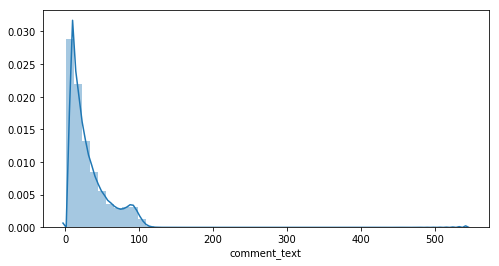

In [12]:
fig, ax = plt.subplots(1, 1, figsize=[8, 4])
sns.distplot(question_lengths, ax=ax)
plt.show()

In [13]:
MAX_STRING_LENGTH = 100

In [14]:
%%time
X_train = get_padded_index_sequence(
    train['comment_text'].str.split(' ').tolist(),
    w2v_model,
    0,
    MAX_STRING_LENGTH
)

Wall time: 13min 6s


In [15]:
%%time
X_test = get_padded_index_sequence(
    test['comment_text'].str.split(' ').tolist(),
    w2v_model,
    0,
    MAX_STRING_LENGTH
)

Wall time: 17.8 s


In [16]:
X_train.iloc[:, :MAX_STRING_LENGTH].to_csv(train_out_path)
X_test.iloc[:, :MAX_STRING_LENGTH].to_csv(test_out_path)